In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import vaemof
from vaemof import experiments
from vaemof import utils
from vaemof.vocabs import SELFIESVocab, MOFVocab, PropVocab
from vaemof import modules
from vaemof import training
from vaemof.model import VAEMOF
from vaemof import configs

from vaemof.utils import header_str
vaemof.experiments.plot_settings()

RDKit WARNING: [01:20:59] Enabling RDKit 2019.09.3 jupyter extensions
/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [21]:
import os
import random
from tqdm.auto import tqdm
import numpy as np
import torch
import rdkit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from itertools import product
from more_itertools import chunked
from collections import OrderedDict

print(f'rdkit : {rdkit.__version__}')
print(f'torch : {torch.__version__}')
print(f'cuda? {torch.cuda.is_available()}')
tqdm.pandas()
utils.disable_rdkit_log()

rdkit : 2019.09.3
torch : 1.4.0
cuda? False


/home/beangoben/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Hparams

In [5]:
preset = 'mof_y'
WORK_DIR = 'results/prop'
hparams = configs.get_model_config(WORK_DIR, preset, rand=False)
print(utils.header_str(preset))
hparams['train_device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

testing = configs.testing_config(hparams)
configs.print_config(hparams)
utils.set_seed(hparams['train_seed'])
device = torch.device(hparams['train_device'])

==================================== mof_y =====================================
==================================== config ====================================
== train == :
        train_device:                 cpu
          train_seed:                  42
    train_batch_size:                  64
        train_epochs:                  20
            train_lr:0.00013138571209279765
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 256
           vae_y_dec:                True
     vae_selfies_dec:               False
         vae_mof_enc:                True
         vae_mof_dec:               False
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:               False
         mof_w_start:                 0.0
           mof_w_end:                 0.5
           mof_start:                  15
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pl

## Load property data

In [6]:
smiles_column = 'branch_smiles'
testtrain_column = 'train/test'
tmp_df = experiments.get_generator_df(csv_file=hparams['files_data'],
                                  smiles_column=smiles_column,
                                  use_duplicates=hparams['vae_duplicate_smiles'],
                                  testing=testing)
ids2mofs, mof2ids, mof_columns = experiments.get_mofdict(tmp_df, hparams['mof_encoding'])
prop_df = experiments.get_prop_df(csv_file=hparams['files_prop'],
                                  targets=hparams['y_labels'],
                                  mof2ids=mof2ids,
                                  testing=testing,
                                  smiles_column=smiles_column,
                                  compute_scscore=True)
prop_df.head()

=================================== Testing ====================================
df shape: (713, 9)
df columns: ['index', 'branch_smiles', 'id2mof', 'metal_node', 'mof_index', 'organic_core', 'randomized', 'topology', 'train/test']
Found 713 unique mofs
=================================== Testing ====================================
Restored variables from data/scscore_1024uint8_model.ckpt-10654.as_numpy.json.gz



Removed 68 datapoints due to mask.
Removed 40 datapoints due non-valid mof (mof2ids).
Removed 4 datapoints due to high selectivity.


,organic_core,metal_node,topology,branch_smiles,lcd,pld,density,avf,avsa,agsa,...,co2ch4_selectivity,co2ch4_heat_avg,co2ch4_heat_co2,co2ch4_heat_ch4,co2ch4_heat_molfrac,selfies_safe,mask,train/test,scscore,id2mof
0,sym_5_vae_70,sym_8_mc_7,scu,[Lr]c1ccc(o1)[Lr],6.92684,3.03360,1.143760,0.00000,0.000,0.00,...,0.000000,0.00000,0.00000,0.00000,0.00000,True,True,1,1.466316,451
1,sym_5_vae_1038,sym_5_mc_2,ssa,[Lr]c1sc(c2c1OCCO2)[Lr],22.43124,20.60178,0.421659,0.56582,1624.620,3852.92,...,3.036957,-12.71150,-18.03664,-11.03007,-12.79457,True,True,0,2.445184,405
2,sym_4_vae_153,sym_9_mc_5,iac,[Lr]c1ccc(cc1)C#C[Lr],14.39486,12.29328,0.468486,0.54877,1846.740,3941.94,...,2.246914,-10.97052,-14.84627,-9.85140,-10.84985,True,True,1,1.743814,186
3,sym_5_vae_BR3264,sym_9_mc_5,soc,[Lr]c1c(C)nn([Lr])c1C,13.94895,10.49463,0.659699,0.41073,1831.680,2776.53,...,4.668019,-16.33142,-22.63069,-13.42098,-16.57039,True,True,1,2.306571,509
4,sym_5_vae_795,sym_4_mc_1,pth,O=C1c2c(c3ccc([Lr])cc31)ccc([Lr])c2,23.45655,21.13022,0.146984,0.78696,967.072,6579.45,...,1.855461,-8.26031,-11.89364,-7.56506,-8.30322,True,True,1,3.012280,257


## Train/test splits and hparams

In [7]:
train_index = np.array(
    prop_df[prop_df[testtrain_column] == 1].index.tolist())
test_index = np.array(
    prop_df[prop_df[testtrain_column] == 0].index.tolist())
print(f'Train/test sizes: {len(train_index):7d} {len(test_index):7d}')

Train/test sizes:     802      86


# Vocabulary and preprocessors

In [10]:
smiles_list = tmp_df[smiles_column].tolist()+prop_df[smiles_column].tolist()
vocab = SELFIESVocab.from_data(smiles_list)
vocab_mof = MOFVocab.from_data(tmp_df.append(
    prop_df, sort=False), mof_columns, weighting=hparams['mof_weighted_loss'])
# scaler type can be power/quantile or None
vocab_y = PropVocab.from_data(
    prop_df, hparams['y_labels'], hparams['y_weights'], scaler_type='power')
vocab, vocab_mof, vocab_y


Alphabet size is 44
Max seq length is 106 with 5 extra padding
Used columns =['metal_node', 'organic_core', 'topology'] with frequency weighting=False
metal_node   has 15 classes
organic_core has 52 classes
topology     has 41 classes


(<vaemof.vocabs.SELFIESVocab at 0x7f56a7cb9890>,
 <vaemof.vocabs.PropVocab at 0x7f56a7cb5390>)

# Instanciate Model

## Careful! (it saves and will overwrite any model previously saved)

In [11]:
try:
    utils.clear_torch(model)
except:
    utils.clear_torch(model=None)

model = VAEMOF(hparams, vocab, vocab_mof, vocab_y).to(device)
model.save()
modules.model_summary(model, include_children=False)

,Name,Module,Extra,submodule,trainable,n_params,trainable_params
0,z_mu,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
1,z_logvar,Linear,"in_features=512, out_features=256, bias=True",False,True,131328,131328
2,enc_x,CharEncoder,,False,True,2268729,2268729
3,enc_mof,MOFEncoder,,False,True,225024,225024
4,dec_y,PropDecoder,,False,True,5418,5397


Trainable params: 2761806 out of 2761827 total (100.00%)


## Prepare train/test 

In [12]:
train_data  = model.df_to_tuples(prop_df.loc[train_index], smiles_column)
test_data = model.df_to_tuples(prop_df.loc[test_index], smiles_column)

## Train

In [13]:
trainer = training.Trainer(hparams)
trainer.train(model, train_data, test_data)

# Results
## Load saved model

In [14]:
hparams_file = os.path.join(WORK_DIR,'config.json')
hparams = configs.AttributeDict.from_jsonfile(hparams_file)
configs.print_config(hparams)
model = VAEMOF.load(hparams)

==================================== config ====================================
== train == :
        train_device:                 cpu
          train_seed:                  42
    train_batch_size:                  64
        train_epochs:                  20
            train_lr:        0.0001313857
     train_clip_grad:                  20
== vae == :
      vae_latent_dim:                 256
           vae_y_dec:                True
     vae_selfies_dec:               False
         vae_mof_enc:                True
         vae_mof_dec:               False
vae_duplicate_smiles:                True
== mof == :
        mof_encoding:                cats
   mof_weighted_loss:               False
         mof_w_start:                 0.0
           mof_w_end:                 0.5
           mof_start:                  15
    mof_const_length:                  10
== y == :
            y_labels:['lcd', 'pld', 'density', 'avf', 'avsa', 'agsa', 'co2n2_co2_mol_kg', 'co2n2_n2_mol_kg', 'co2n2

## Training stats

In [16]:
log_df = pd.read_csv(configs.at_results_dir(hparams,'files_log'))
log_df = log_df.drop(columns=[c for c in log_df.columns if any(l in c for l in ['mof','x', 'kl','ratio'])])
print(log_df.shape)
print(log_df.columns)
log_df.head()

(20, 50)
Index(['epoch', 'test_y', 'test_loss', 'lcd-r2', 'lcd-MAE', 'pld-r2',
       'pld-MAE', 'density-r2', 'density-MAE', 'avf-r2', 'avf-MAE', 'avsa-r2',
       'avsa-MAE', 'agsa-r2', 'agsa-MAE', 'co2n2_co2_mol_kg-r2',
       'co2n2_co2_mol_kg-MAE', 'co2n2_n2_mol_kg-r2', 'co2n2_n2_mol_kg-MAE',
       'co2n2_selectivity-r2', 'co2n2_selectivity-MAE', 'co2n2_heat_avg-r2',
       'co2n2_heat_avg-MAE', 'co2n2_heat_co2-r2', 'co2n2_heat_co2-MAE',
       'co2n2_heat_n2-r2', 'co2n2_heat_n2-MAE', 'co2n2_heat_molfrac-r2',
       'co2n2_heat_molfrac-MAE', 'co2ch4_co2_mol_kg-r2',
       'co2ch4_co2_mol_kg-MAE', 'co2ch4_ch4_mol_kg-r2',
       'co2ch4_ch4_mol_kg-MAE', 'co2ch4_selectivity-r2',
       'co2ch4_selectivity-MAE', 'co2ch4_heat_avg-r2', 'co2ch4_heat_avg-MAE',
       'co2ch4_heat_co2-r2', 'co2ch4_heat_co2-MAE', 'co2ch4_heat_ch4-r2',
       'co2ch4_heat_ch4-MAE', 'co2ch4_heat_molfrac-r2',
       'co2ch4_heat_molfrac-MAE', 'scscore-r2', 'scscore-MAE', 'lr', 'λ_y',
       'train_y', 'train_

,epoch,test_y,test_loss,lcd-r2,lcd-MAE,pld-r2,pld-MAE,density-r2,density-MAE,avf-r2,...,co2ch4_heat_ch4-MAE,co2ch4_heat_molfrac-r2,co2ch4_heat_molfrac-MAE,scscore-r2,scscore-MAE,lr,λ_y,train_y,train_loss,mean_r2
0,0,19.670542,19.670542,0.943861,109.380928,0.966084,92.359512,0.969042,76.499878,0.976425,...,172.119339,-0.574206,197.788696,0.986123,38.064785,0.000131,1.0,28.312948,28.312948,0.812767
1,1,18.086570,18.086570,0.890426,150.895782,0.922251,128.490906,0.967940,77.889389,0.977672,...,151.145630,0.555943,96.643661,0.999739,7.951864,0.000131,1.0,26.566865,26.566865,0.862340
2,2,14.408834,14.408834,0.983987,59.309437,0.953220,95.213020,0.981361,58.473663,0.939948,...,90.338127,0.262307,129.961517,0.991398,27.565247,0.000131,1.0,23.883687,23.883687,0.875387
3,3,11.099390,11.099390,0.972291,72.744492,0.992774,38.553566,0.995723,22.259697,0.896634,...,59.054077,0.392110,118.255951,0.995541,23.539425,0.000131,1.0,19.714368,19.714368,0.912642
4,4,9.309026,9.309026,0.980129,65.251305,0.987319,57.510532,0.992278,38.286324,0.843983,...,78.118637,0.649644,82.447601,0.973364,64.580849,0.000131,1.0,17.574912,17.574912,0.936040


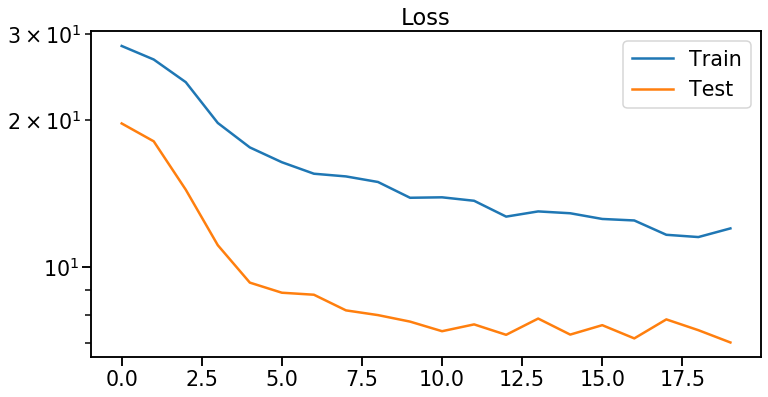

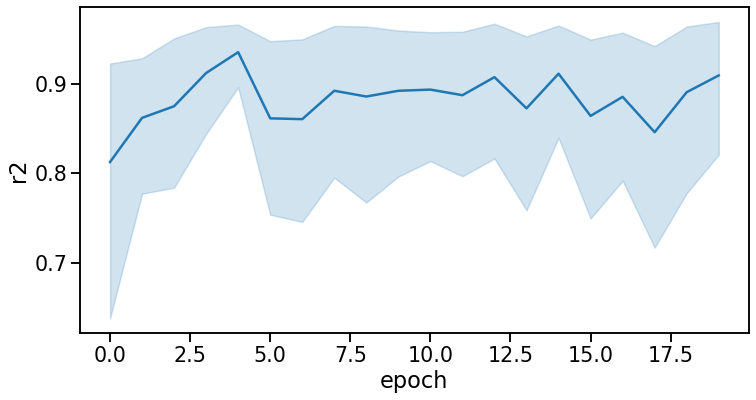

In [18]:
COMPONENTS = training.COMPONENTS
epochs = log_df['epoch'].values

plt.plot(epochs, log_df[f'train_y'], label='Train')
plt.plot(epochs, log_df[f'test_y'], label='Test')
plt.title(f'Loss')
plt.yscale("log")
plt.legend()
plt.show()

results=[]
for label in hparams['y_labels']:
    metric = f'{label}-r2'
    results.extend([{'epoch':epoch,'r2':value,"prop":label} for epoch, value in log_df[['epoch',metric]].values ]  )
prop_df = pd.DataFrame(results)
sns.lineplot(x='epoch',y='r2', data=prop_df)
plt.show()

In [22]:
print(header_str('R^2 scores and MAEs'))
src_data = test_data
batch_size = 256
n_loops = int(np.ceil(len(src_data) / batch_size))
y_pred, y_true = [], []
for chunk in  tqdm(chunked(src_data,batch_size),total=n_loops, desc='Pred'):
    batch = model.tuples_to_tensors(chunk)
    z = model.inputs_to_z(batch['x'],batch['mof'])
    outs = model.z_to_outputs(z)
    y_true.extend(model.vocab_y.inverse_transform(batch['y']))
    y_pred.extend(outs['y'])
    
y_pred = np.stack(y_pred)
y_true = np.stack(y_true)
experiments.regression_statistics(y_true, y_pred, hparams['y_labels'])

============================= R^2 scores and MAEs ==============================


,label,R2,MAE,RMSE
0,lcd,0.646196,5.135036,7.166136
1,pld,0.637770,4.346162,6.164964
2,density,0.486565,0.102796,0.156396
3,avf,0.597773,0.085288,0.118077
4,avsa,0.612730,253.597464,323.952744
5,agsa,0.594079,806.956747,1060.158633
6,co2n2_co2_mol_kg,0.154526,0.057267,0.079879
7,co2n2_n2_mol_kg,0.742331,0.056945,0.073518
8,co2n2_selectivity,0.218714,1.542060,2.386112
9,co2n2_heat_avg,0.341665,2.509178,3.322402
